# Dynamic Case Preparation

In [1]:
import pandas as pd

import matplotlib.pyplot as plt

import andes
import ams

In [2]:
%matplotlib inline

In [3]:
andes.config_logger(stream_level=20)
ams.config_logger(stream_level=20)

In [4]:
sp = ams.load('./ACTIVSg200/IL200_opf.xlsx',
              setup=True, no_output=True,
              default_config=True)

Working directory: "/Users/jinningwang/work/turbinegov"
Parsing input file "./ACTIVSg200/IL200_opf.xlsx"...
Input file parsed in 0.0997 seconds.
Zero Line parameters detected, adjusted to default values: rate_b, rate_c, amax, amin.
System set up in 0.0021 seconds.


## Inspect Case

There are different types of generators.

In [5]:
stg = sp.StaticGen.as_df()
stg.head(15)[['u','name','idx','bus','Sn','gentype','genfuel']]

,u,name,idx,bus,Sn,gentype,genfuel
0,1.0,47,47,189,682.98,NB,nuclear
1,1.0,1,1,49,5.44,ST,coal
2,1.0,2,2,50,5.44,ST,coal
3,1.0,3,3,51,5.44,ST,coal
4,1.0,4,4,52,5.44,ST,coal
5,1.0,5,5,53,10.88,ST,coal
6,1.0,6,6,65,180.48,W2,wind
7,1.0,7,7,67,5.64,ST,coal
8,1.0,8,8,68,33.50,ST,coal
9,1.0,9,9,69,33.50,ST,coal


## Dynamic Models Replacement

In the original dynamic case, only ``GENROU`` and ``TGOV1`` is used.
To better represent the dynamic behavior, following replacements are made:
1. W2 type gen, replace GENROU with Wind Generations
1. ST type gen, replace its TGOV1N with IEEEG1
1. GT type gen, replace its TGOV1N with GAST

In [6]:
# load the dynamics case but don't set up it
sa = andes.load('./ACTIVSg200/IL200_dyn.xlsx',
                setup=False, no_output=True,
                default_config=True)

# add a Toggle to set up a generator trip event
sa.add(model='Toggle', param_dict=dict(u=1, t=1,
                                       model='GENROU', dev='GENROU_2'))

Working directory: "/Users/jinningwang/work/turbinegov"
> Reloaded generated Python code of module "pycode".
Parsing input file "./ACTIVSg200/IL200_dyn.xlsx"...
Input file parsed in 0.0717 seconds.


'Toggle_1'

### GENROU -> [WT2G](https://www.esig.energy/wiki-main-page/wt2-generic-wind-model/) -> Exsiting models

This replacement is a little bit tricky, as we need to map WT2G further to existing models.

1. REGCA1: This model represents the renewable energy generator/converter dynamics. It is the core model for the generator's electrical behavior.
1. REECA1: This model handles the electrical control aspects, such as voltage regulation and reactive power control. It works in conjunction with REGCA1.
1. REPCA1: This model represents plant-level control, including active power control and coordination of multiple turbines within a wind farm.
1. WTPTA1: This model simulates the pitch control mechanism, which adjusts the blade angle to regulate power output and protect the turbine.
1. WTDTA1: This model represents the drive-train dynamics, including the mechanical coupling between the turbine rotor and the generator.
1. WTARA1: This model simulates the aerodynamic behavior of the wind turbine, including the interaction between wind speed and rotor dynamics.

In [7]:
# In the AMS case, get the StaticGen idx for type W2, ST, GT, respectively
stg_idxes = sp.StaticGen.find_idx(keys='gentype',
                                  values=['W2', 'ST', 'GT'],
                                  allow_all=True)
stg_w2t = stg_idxes[0]
stg_st = stg_idxes[1]
stg_gt = stg_idxes[2]

# In the ANDES case, get the corresponding SynGen idx
syg_w2t = sa.SynGen.find_idx(keys='gen', values=stg_w2t)
syg_st = sa.SynGen.find_idx(keys='gen', values=stg_st)
syg_gt = sa.SynGen.find_idx(keys='gen', values=stg_gt)

# Turn off the W2TG, as they will be repalced with renewable generators
# NOTE: we use `alter` here to ensure the changes can be saved
# in the exported case
sa.SynGen.alter(src='u', value=0, idx=syg_w2t)

# In the ANDES case, get the corresponding TurbineGov idx
tg_w2t = sa.TurbineGov.find_idx(keys='syn', values=syg_w2t)
tg_st = sa.TurbineGov.find_idx(keys='syn', values=syg_st)
tg_gt = sa.TurbineGov.find_idx(keys='syn', values=syg_gt)

# Turn off all of them, as some of them will be replaced with
# renewable governors or other governors
sa.TurbineGov.alter(src='u', value=0,
                    idx=tg_w2t + tg_st + tg_gt)

True

### TGOV1N -> [IEEEG1](https://www.powerworld.com/WebHelp/Content/TransientModels_HTML/Governor%20IEEEG1,%20IEEEG1D%20and%20IEEEG1_GE.htm)

|   TGOV1N         |   IEEEG1         |   Notes                       |
|------------------|------------------|--------------------------------|
| Tn               | Tn               | Direct mapping                |
| R                | K                | K = 1/R                       |
| T1               | T1               | Direct mapping                |
| Vmax             | Pmax             | Direct mapping                |
| Vmin             | Pmin             | Direct mapping                |
| T2               | T2               | Direct mapping                |
| T3               | T5               | Reheater time constant        |
| Dt               | --               | Discard                       |

Unmapped parameters: T3, Uo, Uc, K1-K8, T4-T7

In [8]:
# --- convert TGOV1N attached to ST type generators to IEEEG1 ---
IEEEG1 = pd.DataFrame()
# mapped parameters
IEEEG1['u'] = [1] * len(tg_gt)
IEEEG1['idx'] = [f'IEEEG1_{i}' for i in range(1, len(tg_gt)+1)]
IEEEG1['syn'] = sa.TurbineGov.get(src='syn', idx=tg_gt)
IEEEG1['syn2'] = [None] * len(tg_gt)
IEEEG1['Tn'] = sa.TurbineGov.get(src='Tn', idx=tg_gt)
IEEEG1['wref0'] = sa.TGOV1N.get(src='wref0', idx=tg_gt)
IEEEG1['K'] = [1/R for R in sa.TurbineGov.get(src='R', idx=tg_gt)]
IEEEG1['T1'] = sa.TurbineGov.get(src='T1', idx=tg_gt)
IEEEG1['PMAX'] = sa.TurbineGov.get(src='VMAX', idx=tg_gt)
IEEEG1['PMIN'] = sa.TurbineGov.get(src='VMIN', idx=tg_gt)
IEEEG1['T2'] = sa.TurbineGov.get(src='T2', idx=tg_gt)
IEEEG1['T5'] = sa.TurbineGov.get(src='T3', idx=tg_gt)
# unmapped parameters
IEEEG1['UO'] = sa.IEEEG1.UO.default
IEEEG1['UC'] = sa.IEEEG1.UC.default
IEEEG1['T3'] = sa.IEEEG1.T3.default
IEEEG1['T4'] = sa.IEEEG1.T4.default
IEEEG1['T6'] = sa.IEEEG1.T6.default
IEEEG1['T7'] = sa.IEEEG1.T7.default
IEEEG1['K1'] = sa.IEEEG1.K1.default
IEEEG1['K3'] = sa.IEEEG1.K3.default
IEEEG1['K5'] = sa.IEEEG1.K5.default
IEEEG1['K7'] = sa.IEEEG1.K7.default
IEEEG1['K2'] = sa.IEEEG1.K2.default
IEEEG1['K4'] = sa.IEEEG1.K4.default
IEEEG1['K6'] = sa.IEEEG1.K6.default
IEEEG1['K8'] = sa.IEEEG1.K8.default

# --- add the IEEEG1 to the system ---
for row in IEEEG1.itertuples(index=False):
    sa.IEEEG1.add(**row._asdict())

### TGOV1N -> [GAST](https://www.powerworld.com/WebHelp/Content/TransientModels_HTML/Governor%20GAST_PTI%20and%20GASTD.htm)

|   TGOV1N         |   GAST           |   Notes                       |
|------------------|------------------|--------------------------------|
| Tn               | Tn               | Direct mapping                |
| R                | R                | Direct mapping                |
| T1               | T1               | Direct mapping                |
| Vmax             | Vmax             | Direct mapping                |
| Vmin             | Vmin             | Direct mapping                |
| T2               | T2               | Direct mapping                |
| T3               | T3               | Direct mapping                |
| Dt               | Dturb            | Direct mapping                |

Unmapped parameters: Kt, At

In [9]:
# --- convert TGOV1N attached to GT type generators to GAST ---
GAST = pd.DataFrame()
# mapped parameters
GAST['u'] = [1] * len(tg_gt)
GAST['idx'] = [f'GAST_{i}' for i in range(1, len(tg_gt)+1)]
GAST['syn'] = sa.TurbineGov.get(src='syn', idx=tg_gt)
GAST['Tn'] = sa.TurbineGov.get(src='Tn', idx=tg_gt)
GAST['wref0'] = sa.TurbineGov.get(src='wref0', idx=tg_gt)
GAST['R'] = sa.TurbineGov.get(src='R', idx=tg_gt)
GAST['VMAX'] = sa.TurbineGov.get(src='VMAX', idx=tg_gt)
GAST['VMIN'] = sa.TurbineGov.get(src='VMIN', idx=tg_gt)
GAST['T2'] = sa.TurbineGov.get(src='T2', idx=tg_gt)
GAST['T3'] = sa.TurbineGov.get(src='T3', idx=tg_gt)
GAST['Dt'] = sa.TurbineGov.get(src='Dt', idx=tg_gt)
# unmapped parameters
GAST['KT'] = sa.GAST.KT.default
GAST['AT'] = sa.GAST.AT.default

# --- add the GAST to the system ---
for row in GAST.itertuples(index=False):
    sa.GAST.add(**row._asdict())

In [10]:
# Export to XLSX for Further Use

andes.io.xlsx.write(sa, 'ACTIVSg200/IL200_dyn_base.xlsx',
                    overwrite=True)

xlsx file written to "ACTIVSg200/IL200_dyn_base.xlsx"


True

## Test TDS

In [11]:
sa.setup()

System internal structure set up in 0.0183 seconds.


True

In [12]:
sa.PFlow.run()

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: Off
   Sparse solver: KLU
 Solution method: NR method
Power flow initialized in 0.0037 seconds.
0: |F(x)| = 0.008972060491
1: |F(x)| = 2.370463282e-06
2: |F(x)| = 2.678968158e-13
Converged in 3 iterations in 0.0032 seconds.


True

In [13]:
_ = sa.TDS.init()

GENROU (vf range) out of typical lower limit.

   idx     | values | limit
-----------+--------+------
 GENROU_6  | 0      | 1    
 GENROU_7  | 0.957  | 1    
 GENROU_16 | 0      | 1    
 GENROU_17 | 0      | 1    
 GENROU_20 | 0      | 1    
 GENROU_22 | 0      | 1    
 GENROU_23 | 0      | 1    
 GENROU_24 | 0      | 1    
 GENROU_25 | 0      | 1    
 GENROU_31 | 0      | 1    
 GENROU_37 | 0      | 1    
 GENROU_38 | 0      | 1    
 GENROU_39 | 0      | 1    
 GENROU_40 | 0      | 1    
 GENROU_42 | 0      | 1    
 GENROU_43 | 0      | 1    
 GENROU_48 | 0      | 1    
 GENROU_49 | 0      | 1    


Initialization for dynamics completed in 0.0260 seconds.
Initialization was successful.


In [14]:
sa.TDS.config.tf = 40
sa.TDS.config.criteria = 0
sa.TDS.config.no_tqdm = True

sa.TDS.run()


-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-40 s.
Fixed step size: h=33.33 ms. Shrink if not converged.


<Toggle Toggle_1>: GENROU.GENROU_2 status changed to 0 at t=1.0 sec.


Simulation to t=40.00 sec completed in 2.2452 seconds.


True

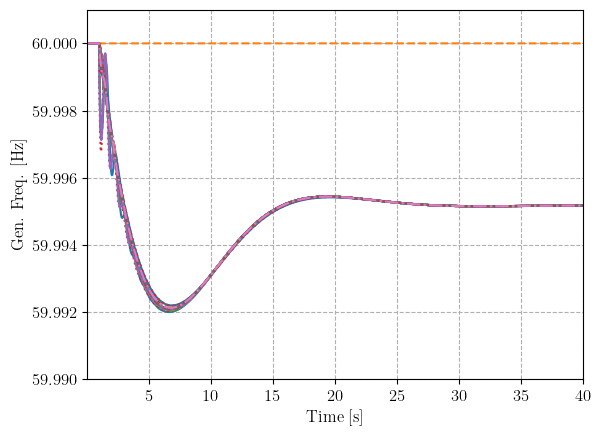

In [15]:
_ = sa.TDS.plt.plot(sa.GENROU.omega,
                    line_width=1.5,
                    ymin=59.99, ymax=60.001,
                    ytimes=sa.config.freq,
                    show=False, grid=True,
                    ylabel='Gen. Freq. [Hz]')